- which subgraphs actually touch the final layer?
- which subgraphs actually touch the final layer and contain the correct class as a node in the subgraph?
- are nearest neighbors represented as nearest neighbors in graph space?
- what are the nearest neighbors of the additional graph structure induced by the adversary?

In [1]:
import os
import parse
import umap

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.neighbors import NearestNeighbors

from pt_activation.functions.nnlayout import draw_neural_net
from pt_activation.models.cff import CFF

%load_ext autoreload
%autoreload 2

/home/tgebhart/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/carliniwagnerl2/cff_relu.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 0, 'pin_memory': False}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 28*28))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'ex':s+t,'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(28*28)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'ex':s+t,'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/cff_relu.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, nms, wms, ims = create_filtrations(model, 50, 300)

Filtration: 0
filtration size 52676
Filtration: 1
filtration size 69019
Filtration: 2
filtration size 35621
Filtration: 3
filtration size 76419
Filtration: 4
filtration size 63063
Filtration: 5
filtration size 38854
Filtration: 6
filtration size 63745
Filtration: 7
filtration size 54862
Filtration: 8
filtration size 75657
Filtration: 9
filtration size 66299
Filtration: 10
filtration size 81093
Filtration: 11
filtration size 77782
Filtration: 12
filtration size 56424
Filtration: 13
filtration size 74440
Filtration: 14
filtration size 39990
Filtration: 15
filtration size 77578
Filtration: 16
filtration size 65254
Filtration: 17
filtration size 57303
Filtration: 18
filtration size 85852
Filtration: 19
filtration size 54410
Filtration: 20
filtration size 59929
Filtration: 21
filtration size 58309
Filtration: 22
filtration size 67514
Filtration: 23
filtration size 66688
Filtration: 24
filtration size 57722
Filtration: 25
filtration size 96710
Filtration: 26
filtration size 48293
Filtration:

filtration size 74287
Filtration: 220
filtration size 59482
Filtration: 221
filtration size 77863
Filtration: 222
filtration size 89106
Filtration: 223
filtration size 55641
Filtration: 224
filtration size 33342
Filtration: 225
filtration size 80439
Filtration: 226
filtration size 74301
Filtration: 227
filtration size 49328
Filtration: 228
filtration size 36881
Filtration: 229
filtration size 42565
Filtration: 230
filtration size 61891
Filtration: 231
filtration size 60576
Filtration: 232
filtration size 68973
Filtration: 233
filtration size 68126
Filtration: 234
filtration size 47326
Filtration: 235
filtration size 59558
Filtration: 236
filtration size 60683
Filtration: 237
filtration size 57880
Filtration: 238
filtration size 64401
Filtration: 239
filtration size 36768
Filtration: 240
filtration size 68111
Filtration: 241
filtration size 77189
Filtration: 242
filtration size 70473
Filtration: 243
filtration size 63321
Filtration: 244
filtration size 51630
Filtration: 245
filtration s

In [7]:
# adv_df, adv_nms, adv_wms = create_adversary_filtrations(model, 50, 100, adversaries)

In [36]:
def compute_nearest_neighbors(ims):
    ret = np.zeros((ims.shape[0],ims.shape[0]))
    for i in range(ims.shape[0]):
        for j in range(ims.shape[0]):
#             nbrs = NearestNeighbors(n_neighbors=10).fit(ret_ims)
#             ret = nbrs.kneighbors(ret_ims)
#             for i in range(data.shape[0]):
#                 for j in range(data.shape[0]):
            ret[i,j] = np.linalg.norm(ims[i] - ims[j], 0)
                
    return ret

def nearest_neighbors_umap(ims, n_neighbors=15, min_dist=0.1, n_components=10, metric='euclidean'):
    ret = np.zeros((ims.shape[0], ims.shape[0]))
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embedding = reducer.fit_transform(ims)
    for i in range(embedding.shape[0]):
        for j in range(embedding.shape[0]):
            ret[i,j] = 1/(1+np.linalg.norm(embedding[i] - embedding[j]))
    return ret
    

In [37]:
nns = nearest_neighbors_umap(ims)

In [14]:
res_df.head()

,class,ex,filtration,loss,prediction
0,7,0,"[(2430), (2447), (2430, 2447), (2439), (2445),...",-14.049807,7
1,2,1,"[(3123), (3140), (3123, 3140), (3138), (3123, ...",-15.757190,2
2,1,2,"[(1670), (1710), (1670, 1710), (1688), (1716),...",-9.077868,1
3,0,3,"[(3484), (3501), (3484, 3501), (3458), (3498),...",-0.000041,0
4,4,4,"[(2864), (2904), (2864, 2904), (2857), (2906),...",-10.368915,4


In [15]:
ids = [{v: k for k, v in nm.items()} for nm in nms]

In [16]:
def create_sample_graphs(res_df, ids, wms):
    sample_graphs = []
    dgms = []
    lifetimes = []
    for s in range(res_df.shape[0]):
        print(s)
        wm = wms[s]
        tnms = ids[s]
        subgraphs = {}
        f = res_df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgm = dion.init_diagrams(m,f)[0]
        dgms.append(dgm)
        for i,c in enumerate(m):
            if len(c) == 2:
                w = f[i].data
                if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                    w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
                elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                    w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
                if False: #tnms[f[c[0].index][0]] in subgraphs:
                    subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(tnms[f[c[0].index][0]]):
                            if tnms[f[c[1].index][0]] in subgraphs:
                                v.add_node(f[c[1].index][0])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                            else:
                                v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        subgraphs[tnms[f[c[0].index][0]]] = g
                        
        sample_graphs.append(subgraphs)
        lifetimes.append(create_lifetimes(f, subgraphs,dgm,ids[s]))
    return sample_graphs, dgms, lifetimes

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]] 
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes
    

In [17]:
sample_graphs, dgms, lifetimes = create_sample_graphs(res_df, ids, wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
res_df.head(10)

,class,ex,filtration,loss,prediction
0,7,0,"[(2430), (2447), (2430, 2447), (2439), (2445),...",-14.049807,7
1,2,1,"[(3123), (3140), (3123, 3140), (3138), (3123, ...",-15.757190,2
2,1,2,"[(1670), (1710), (1670, 1710), (1688), (1716),...",-9.077868,1
3,0,3,"[(3484), (3501), (3484, 3501), (3458), (3498),...",-0.000041,0
4,4,4,"[(2864), (2904), (2864, 2904), (2857), (2906),...",-10.368915,4
5,1,5,"[(1804), (1844), (1804, 1844), (1822), (1850),...",-12.010099,1
6,4,6,"[(2958), (3007), (2958, 3007), (2964), (3009),...",-20.694860,4
7,9,7,"[(2520), (2529), (2520, 2529), (2485), (2485, ...",-18.227373,9
8,5,8,"[(3436), (3444), (3436, 3444), (3440), (3436, ...",-15.517090,5
9,9,9,"[(3027), (3044), (3027, 3044), (3038), (3027, ...",-16.870689,9


In [19]:
goi = 2

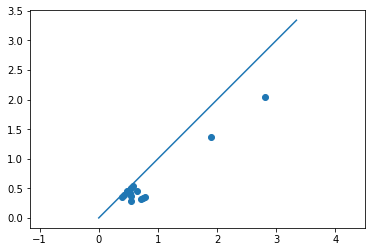

In [20]:
dion.plot.plot_diagram(dgms[goi])

In [21]:
lifetimes[goi]

{(2, 0, 13): 3.3406200408935547,
 (2, 0, 31): 0.7762715816497803,
 (2, 0, 43): 0.5340605974197388,
 (2, 0, 5): 0.4205711781978607,
 (1, 0, 2699): 0.19651612639427185,
 (1, 0, 2605): 0.031099975109100342,
 (1, 0, 2794): 0.04611882567405701,
 (2, 0, 45): 0.17136070132255554,
 (1, 0, 2746): 0.11099600791931152,
 (1, 0, 2438): 0.03229576349258423,
 (1, 0, 2509): 0.03379443287849426,
 (1, 0, 2724): 0.029178351163864136}

In [22]:
sgk = (2,0,13)

/home/tgebhart/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


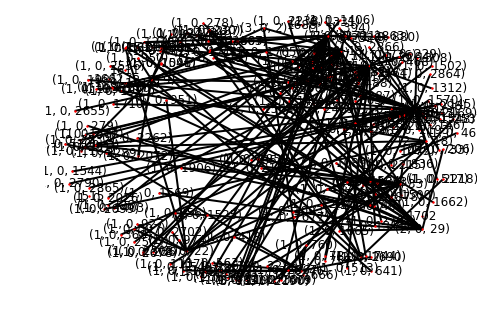

In [23]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(sample_graphs[goi][sgk], **options)

In [24]:
sample_graphs[goi][sgk].edges(data=True)

EdgeDataView([((2, 0, 13), (3, 0, 3), {'weight': -3.34062}), ((2, 0, 13), (3, 0, 2), {'weight': 2.756112}), ((2, 0, 13), (3, 0, 1), {'weight': 2.5632699}), ((2, 0, 13), (3, 0, 7), {'weight': 2.4175138}), ((2, 0, 13), (3, 0, 5), {'weight': -1.9163411}), ((2, 0, 13), (1, 0, 2701), {'weight': -0.25530976}), ((2, 0, 13), (1, 0, 2725), {'weight': -0.22797514}), ((2, 0, 13), (1, 0, 2721), {'weight': 0.1704719}), ((2, 0, 13), (1, 0, 971), {'weight': 0.14323916}), ((2, 0, 13), (1, 0, 2678), {'weight': -0.11548342}), ((2, 0, 13), (1, 0, 947), {'weight': 0.08059851}), ((2, 0, 13), (1, 0, 1018), {'weight': 0.066846125}), ((2, 0, 13), (1, 0, 2050), {'weight': 0.039710347}), ((2, 0, 13), (1, 0, 2216), {'weight': 0.03876467}), ((2, 0, 13), (1, 0, 1521), {'weight': 0.033501316}), ((2, 0, 13), (1, 0, 994), {'weight': 0.030887507}), ((2, 0, 13), (1, 0, 1549), {'weight': -0.02430929}), ((2, 0, 13), (1, 0, 2655), {'weight': -0.02078159}), ((2, 0, 13), (1, 0, 1568), {'weight': 0.013592313}), ((2, 0, 13), 

In [25]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [26]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

,class,ex,filtration,loss,prediction
71,0,71,"[(3974), (4000), (3974, 4000), (3982), (3999),...",0.000000,0
188,0,188,"[(3637), (3654), (3637, 3654), (3629), (3655),...",0.000000,0
25,0,25,"[(4279), (4305), (4279, 4305), (4300), (4279, ...",-0.000010,0
259,6,259,"[(3460), (3500), (3460, 3500), (3481), (3503),...",-0.021935,0
148,0,148,"[(3202), (3219), (3202, 3219), (3176), (3216),...",-0.000455,0


In [27]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

comb_sim_mat = np.zeros((len(sample_graphs), len(sample_graphs)))
sidx = list(sorted_res_df.index)
for i in range(len(sample_graphs)):
    ix = sidx[i]
    for j in range(len(sample_graphs)):
        jx = sidx[j]
        comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[ix],sample_graphs[jx],lifetimes[ix],lifetimes[jx])
        

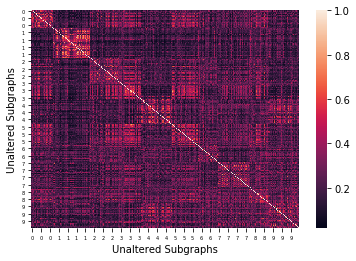

In [28]:
csmdf = pd.DataFrame(comb_sim_mat, columns=sorted_res_df['prediction'], index=sorted_res_df['prediction'])
# ax = sns.heatmap(comb_sim_mat, xticklabels=sorted_res_df['prediction'],yticklabels=sorted_res_df['prediction'])
ax = sns.heatmap(csmdf, xticklabels=10, yticklabels=10)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Unaltered Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_mnist/comb_heatmap_no_adv.png', format='png', dpi=500)

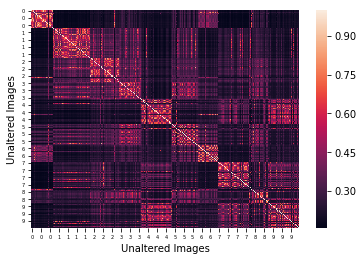

In [38]:
sorted_nns = np.empty(nns.shape)
sidxs = list(sorted_res_df.index)
for i in range(len(sidxs)):
    for j in range(len(sidxs)):
        sorted_nns[i,j] = nns[sidxs[i],sidxs[j]]
        
snnsdf = pd.DataFrame(sorted_nns, columns=sorted_res_df['prediction'], index=sorted_res_df['prediction'])
ax = sns.heatmap(snnsdf, xticklabels=10, yticklabels=10)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Images')
plt.xlabel('Unaltered Images')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_mnist/nnsim.png', format='png', dpi=500)

In [30]:
comb_sim_mat2 = np.zeros((len(sample_graphs), len(sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(sample_graphs)):
        comb_sim_mat2[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],sample_graphs[j],lifetimes[i],lifetimes[j])
    

In [68]:
ngoi = 4
res_df.iloc[ngoi].head()

class                                                         4
ex                                                            4
filtration    [(2864), (2904), (2864, 2904), (2857), (2906),...
loss                                                   -10.3689
prediction                                                    4
Name: 4, dtype: object

In [69]:
# Nearest neighbors in graph space
res_df.iloc[comb_sim_mat2[ngoi,:].argsort()[-10:][::-1]]

,class,ex,filtration,loss,prediction
4,4,4,"[(2864), (2904), (2864, 2904), (2857), (2906),...",-10.368915,4
248,4,248,"[(3281), (3321), (3281, 3321), (3274), (3323),...",-16.425400,4
49,4,49,"[(2929), (2969), (2929, 2969), (2922), (2971),...",-14.300601,4
105,9,105,"[(2644), (2661), (2644, 2661), (2655), (2644, ...",-14.612291,9
133,7,133,"[(3253), (3281), (3253, 3281), (3225), (3277),...",-18.302332,7
150,9,150,"[(2855), (2888), (2855, 2888), (2849), (2893),...",-16.443890,9
119,2,119,"[(3335), (3384), (3335, 3384), (3333), (3388),...",-10.591381,2
104,9,104,"[(2897), (2914), (2897, 2914), (2908), (2897, ...",-15.295244,9
259,6,259,"[(3460), (3500), (3460, 3500), (3481), (3503),...",-0.021935,0
56,4,56,"[(3141), (3190), (3141, 3190), (3148), (3188),...",-20.334446,4


In [70]:
# Nearest neighbors in image space
res_df.iloc[nns[ngoi,:].argsort()[-10:][::-1]]

,class,ex,filtration,loss,prediction
4,4,4,"[(2864), (2904), (2864, 2904), (2857), (2906),...",-10.368915,4
275,4,275,"[(2929), (2973), (2929, 2973), (2926), (2966),...",-15.222868,4
27,4,27,"[(2768), (2812), (2768, 2812), (2765), (2805),...",-18.805756,4
49,4,49,"[(2929), (2969), (2929, 2969), (2922), (2971),...",-14.300601,4
103,4,103,"[(3045), (3071), (3045, 3071), (3027), (3067),...",-19.938290,4
16,9,16,"[(2954), (2987), (2954, 2987), (2945), (2985),...",-9.840941,9
163,4,163,"[(3105), (3154), (3105, 3154), (3112), (3152),...",-20.568108,4
105,9,105,"[(2644), (2661), (2644, 2661), (2655), (2644, ...",-14.612291,9
8,5,8,"[(3436), (3444), (3436, 3444), (3440), (3436, ...",-15.517090,5
56,4,56,"[(3141), (3190), (3141, 3190), (3148), (3188),...",-20.334446,4


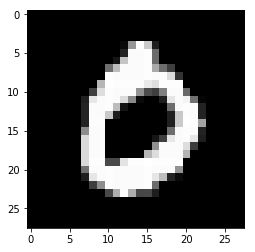

In [66]:
plt.imshow(ims[ngoi].reshape(28,28), cmap='gray')

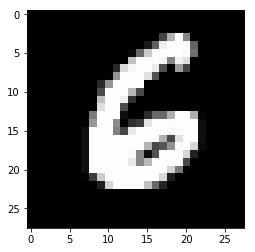

In [67]:
plt.imshow(ims[131].reshape(28,28), cmap='gray')